# Outlier Detection  🔎
##  Objective
In this notebook, as a second approach, we aim to develop machine learning models capable of identifying erroneous data points within our ornithological datasets. Unlike our previous approach that primarily focused on temporal and spatial information through Emergent Filters, this machine learning approach employs anomaly detection algorithms such as Isolation Forests, One-Class SVM, and autoencoders, which enable us to incorporate more sophisticated features, including those provided by ornitho.de (such as Atlas Code) and self-created features derived from them (like land use, weather, and altitude), into the anomaly detection process. We anticipate that the incorporation of such supplementary information will render more precise validity assessments of the data point.

## Scope
Our investigation in this notebook aims to achieve two significant outcomes. Firstly, we intend to accurately distinguish between valid and invalid data points using afore-mentioned anomaly detection algorithms. Secondly, we aim to augment our anomaly detection process with interpretability. We employ Shapley values to unravel the decision-making process of our models, pinpointing the pivotal features that lead to the classification of a data point as erroneous. This transparent approach not only provides valuable insights for model evaluation but also potentially provides additional assistance to reviewers during error assessment.
***

You can download the data needed to run this code [here](https://drive.google.com/drive/folders/18XoTsDtWnN4QdIBNGGbq-jaa6U3nVb2e).<br>

In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "Itim"
    }
</style>

In [2]:
%reload_ext autoreload

import sys
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import pandas as pd
import plotly.express as px
import shap
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

from utils.data_preparation import *
from simon.utils.feature_generation import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 1️⃣ Data selection and preparation

#### Load and standardize data
For this notebook, we are using the standardized dataset containing bird sightings data from both Switzerland and Germany spanning from 2018 to 2022. It already contains our self-generated features `altitude` and `land_use`. You can download it [here](https://drive.google.com/drive/folders/18XoTsDtWnN4QdIBNGGbq-jaa6U3nVb2e).

Additionally, we apply the validation dataset provided by ornitho.ch and ornitho.de for evaluation, comprising both correct and manually falsified data points from 2023. This data will be standardized according to the steps taken in *bird-sighting-validation/marina/01_data_preparation/04_data_preparation_summary.ipynb*.

In [3]:
# Data we want to train on
path_train = '../../../01_Data/datasets/selected_species_50km_luse.csv'  # Provide local path to selected_species_50km_luse.csv
train_data = pd.read_csv(path_train, index_col=0, low_memory=False).reset_index(drop=True)

In [4]:
# Data we want to predict on
path_validata = '../../../01_Data/datasets/validata_ornitho_ch_2023.csv'
date_format = '%d.%m.%Y'  # ch: '%d.%m.%Y'; de: %m/%d/%Y

# Data we need for data preparation
path_translator_names = '../../../01_Data/translators/translation_species_names_de_vs_ch.csv'
path_eea_grids = '../../../01_Data/shp_files/grids/eea_europe_grids_50km/inspire_compatible_grid_50km.shp'

# Load and standardize validation data
validata = pd.read_csv(path_validata, delimiter=get_delimiter(path_validata), low_memory=False)
validata = standardize_data(validata, 
                            date_format=date_format,
                            path_translator_species_names=path_translator_names,
                            eea_shapefile_path=path_eea_grids)
validata.total_count = validata.total_count.astype(float)
validata.altitude = validata.altitude.astype(float)

# Add land use feature accodring to CORINE Land Cover
validata = generate_land_use_clc(validata)

#### Data selection
Recognizing the intricate diversity of bird species, it becomes evident that each bird species possesses its own distinctive set of behaviors and preferences. For instance, migration times and preferred habitats exhibit substantial variations among different species.
Therefore, as discussed with the ornithologists, we refrained from training a single model for multiple species to avoid generalization errors. Instead, individualized models will be developed for each bird species. By adopting this approach, we aim to capture the specific patterns inherent to each species, ensuring that our conclusions about the validity of bird sightings are grounded in the nuanced understanding of each species' behavior.

We have chosen to prototype our model implementation for the water pipit (ger. *Bergpieper*, depicted below), one of the 27 bird species selected by ornitho.de and ornitho.ch, as it has a medium occurrence frequency in our dataset.


<img src="https://www.lfu.bayern.de/natur/sap/arteninformationen/bild/zeige/224838" alt="A water pipit." style="border-radius: 7px;">

In [5]:
bergpieper_train = train_data[train_data.name_species == 'Bergpieper']
bergpieper_test = validata[validata.name_species == 'Bergpieper']

In [6]:
bergpieper_train.head()

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,country,eea_grid_id,Numerical_LUSE,LUSE
12,29658979,469.0,Bergpieper,2018-01-01,NaN,52.321750,10.432800,place,67.174774,2.0,0,106288.0,de,50kmE4350N3200,3,Agriculture
30,29661644,469.0,Bergpieper,2018-01-01,NaN,49.144776,10.690435,square,414.630200,3.0,0,70588.0,de,50kmE4350N2850,3,Agriculture
39,29653403,469.0,Bergpieper,2018-01-01,NaN,51.022837,6.208935,place,48.621960,1.0,0,63657.0,de,50kmE4050N3100,3,Agriculture
41,29677384,469.0,Bergpieper,2018-01-01,NaN,51.022837,6.208935,place,48.621960,1.0,0,40350.0,de,50kmE4050N3100,3,Agriculture
44,29681835,469.0,Bergpieper,2018-01-01,NaN,49.872006,12.239931,precise,469.780550,2.0,0,40956.0,de,50kmE4450N2950,3,Agriculture


In [7]:
bergpieper_test.head()

,id_validata,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,eea_grid_id,Numerical_LUSE,LUSE
16,17,NaN,469,Bergpieper,2023-07-10,NaN,47.567153,7.551575,square,280.0,10.0,0,9110,50kmE4100N2700,3,Agriculture
509,510,NaN,469,Bergpieper,2023-03-25,10:02:32,46.155468,8.865485,precise,190.0,1.0,0,1504,50kmE4200N2550,6,Water
510,511,NaN,469,Bergpieper,2023-04-14,18:24:20,46.162629,8.857722,precise,190.0,1.0,0,14504,50kmE4200N2550,6,Water
511,512,NaN,469,Bergpieper,2023-03-18,08:00:42,46.163578,8.855934,precise,190.0,1.0,0,8386,50kmE4200N2550,6,Water
512,513,NaN,469,Bergpieper,2023-01-31,13:31:02,46.162629,8.857658,precise,190.0,1.0,0,13152,50kmE4200N2550,6,Water


#### Feature selection
Not all features in the dataset depicted above are considered suitable or informative for the outlier analysis. Consequently, we exclude the following features from consideration, as they do not provide additional information for assessing validity:
- `id_validata`
- `id_sighting`
- `id_species`
- `name_species`
- `precision`

Additionally, we omit the `id_observer` feature, as there are no unusual observer IDs, and a combination of `id_observer` and a bird sighting should not lead to the assumption of an outlier.

Furthermore, due to the feature's sparsity in the training dataset, we exclude the features `timing` (59.3% unspecified) and `atlas_code` (78.1.6% unspecified) from our analysis:

In [8]:
print('Percentage of unspecified timing feature:', train_data.timing.isna().sum() / len(train_data))
grouped_atlas_codes = condense_atlas_codes(train_data.atlas_code)
print('Percentage of unspecified atlas code feature:', (grouped_atlas_codes == 0).sum() / len(train_data))

Percentage of unspecified timing feature: 0.5928272588074704
Percentage of unspecified atlas code feature: 0.780635501005059


We also omit `eea_grid_id`, as the spatial information is also already depicted more precisely in `coord_lat` and `coord_lon`.

Lastly, we remove `LUSE` as it holds the same information as `NumericalLUSE` but as string literals.

All other features will be incorporated to our outlier analysis:

In [9]:
bergpieper_train = bergpieper_train[['date', 'coord_lat', 'coord_lon', 'altitude', 'total_count','Numerical_LUSE']]
bergpieper_test = bergpieper_test[['date', 'coord_lat', 'coord_lon', 'altitude', 'total_count', 'Numerical_LUSE']]
bergpieper_train.head()

,date,coord_lat,coord_lon,altitude,total_count,Numerical_LUSE
12,2018-01-01,52.321750,10.432800,67.174774,2.0,3
30,2018-01-01,49.144776,10.690435,414.630200,3.0,3
39,2018-01-01,51.022837,6.208935,48.621960,1.0,3
41,2018-01-01,51.022837,6.208935,48.621960,1.0,3
44,2018-01-01,49.872006,12.239931,469.780550,2.0,3


#### Feature preparation
Since outlier detection methods operate exclusively on numerical values, we will adjust all features accordingly.

In [10]:
# Turn date into day of year
bergpieper_train.date = pd.to_datetime(bergpieper_train.date).dt.dayofyear
bergpieper_test.date = pd.to_datetime(bergpieper_test.date).dt.dayofyear

In [11]:
# Remove letters from eea_grid_id's and turn them into integers
#bergpieper_train.eea_grid_id = numerize_eea_grids(bergpieper_train.eea_grid_id)
#bergpieper_test.eea_grid_id = numerize_eea_grids(bergpieper_test.eea_grid_id)

In [12]:
# Replace NaNs in total_count with 1 (default value)
bergpieper_train.total_count = bergpieper_train.total_count.fillna(1)
bergpieper_test.total_count = bergpieper_test.total_count.fillna(1)

## 2️⃣ Modeling
Our objective is to formulate an outlier detection model proficient in identifying bird sightings that deviate from the species' norms. This model will be exclusively trained on valid data points spanning from 2018 to 2022. Subsequently, we will assess its proficiency in identifying outliers using a curated test dataset from 2023 which has been augmented with anomalies introduced by the ornithologists.

### Train models
Three commonly used outlier algorithms will be trained: Isolation Forest, Local Outlier Factor, and One-Class SVM, initially with their default hyperparameters. These can be tuned and adjusted in a subsequent deep-dive. After training, the models predict whether a data point in the validation dataset is an valid (=1) or possibly faulty (=-1). For each algorithm, the percentage of recognized outlier models is returned.

In [13]:
isolation_forest = IsolationForest(contamination='auto', random_state=0)
isolation_forest.fit(bergpieper_train)

prediction_if = isolation_forest.predict(bergpieper_test)  # inliers=1; outliers=-1
outliers_if = bergpieper_test[prediction_if == -1]

print('Number of detected anomalies:', len(outliers_if), '/', len(bergpieper_test))
print('Percentage of anomalies:', round(len(outliers_if)/len(bergpieper_test)*100,2), '%')

Number of detected anomalies: 526 / 6431
Percentage of anomalies: 8.18 %


In [14]:
lof = LocalOutlierFactor(contamination='auto')
lof.fit(bergpieper_train)

prediction_lof = lof.fit_predict(bergpieper_test)  # inliers=1; outliers=-1
outliers_lof = bergpieper_test[prediction_lof == -1]

print('Number of detected anomalies:', len(outliers_lof), '/', len(bergpieper_test))
print('Percentage of anomalies:', round(len(outliers_lof)/len(bergpieper_test)*100,2), '%')

Number of detected anomalies: 401 / 6431
Percentage of anomalies: 6.24 %


In [15]:
svm = OneClassSVM()
svm.fit(bergpieper_train)

prediction_svm = svm.predict(bergpieper_test)  # inliers=1; outliers=-1
outliers_svm = bergpieper_test[prediction_svm == -1]

print('Number of detected anomalies:', len(outliers_svm), '/', len(bergpieper_test))
print('Percentage of anomalies:', round(len(outliers_svm)/len(bergpieper_test)*100,2), '%')

Number of detected anomalies: 6431 / 6431
Percentage of anomalies: 100.0 %


### Add interpretability with Shapley
In order to gain an initial insight into the internal functioning of the models, we employ Shapley values. Shapley values offer a systematic methodology for comprehending the significance of features within the model's decision-making process.

Additionally, we aim to utilize Shapley values to identify, on a per-data-point basis, which feature has predominantly contributed to the model categorizing a data point as an outlier. This approach could assist reviewers in pinpointing the potential source of error within the data point.

#### Feature importance across all data points
For the Isolation Forest, we observe that the altitude of the points had the most significant explanatory power.  Similarly, both the number of birds and land use appear to have a significant influence on the model's predictions. 

The informativeness of a feature provides insights into which features were influential for model predictions. However, it needs to be emphasized that the conclusions drawn based on these features may not necessarily be accurate. Therefore, it needs to be determined whether the outliers identified based on these impactful features were correctly recognized.

 97%|=================== | 6266/6431 [00:32<00:00]       

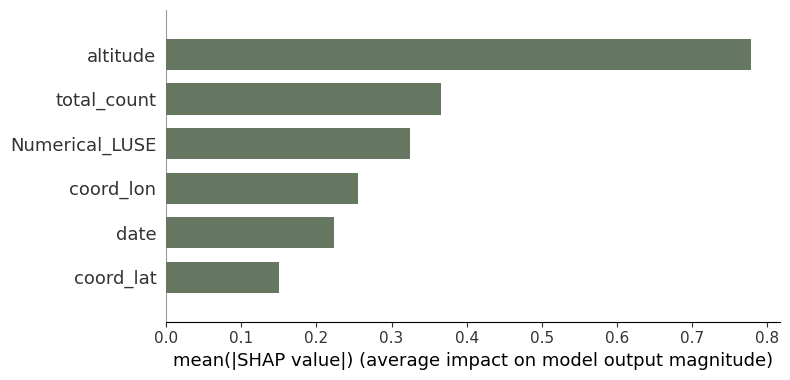

In [16]:
explainer_if = shap.Explainer(isolation_forest, bergpieper_test)
shap_values_if = explainer_if.shap_values(bergpieper_test)
shap.summary_plot(shap_values_if, bergpieper_test, plot_type='bar', color='#667761')

#### Feature importance for a specific data point

With Shapley, it is also possible to display a bar plot specifically illustrating the contribution of individual features to the prediction for that particular data point.
From the plot, we can derive:
- **Feature Importance Magnitude:** The height of each bar represents the magnitude of the SHAP values for a specific feature with respect to the prediction for the given data point. A taller bar indicates a feature's higher impact on the prediction for that specific instance.

- **Direction of Impact:** The color of the bars can indicate the direction of the impact of each feature on the prediction. Positive impact (features contributing to a higher prediction) might be a different color from negative impact (features contributing to a lower prediction).

- **Ranked Feature Importance for the Specific Data Point:** The order of the bars, from left to right, represents the ranking of features based on their individual SHAP values for the specific data point. Features on the left side have a higher impact on the prediction for this instance compared to features on the right side.

Below, we choose a single sighting of a water pipit and create a Shapley bar plot for it:

In [31]:
bergpieper_test.iloc[4]

date               31.000000
coord_lat          46.162629
coord_lon           8.857658
altitude          190.000000
total_count         1.000000
Numerical_LUSE      6.000000
Name: 512, dtype: float64

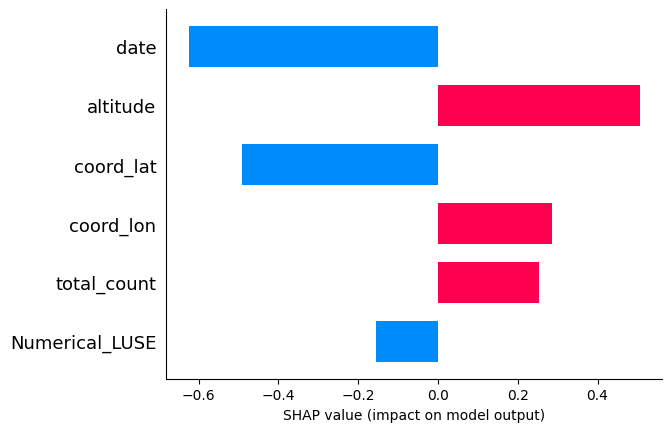

In [30]:
shap.initjs()
shap_values_dp = explainer_if.shap_values(bergpieper_test.iloc[4])
shap.bar_plot(shap_values_dp, feature_names=bergpieper_test.columns)

In the presented plot, it is evident that the model identifies the date, latitude, and land use as atypical factors, pulling the data point closer to an outlier classification. Conversely, altitude, longitude, and count values appear unremarkable, not suggesting an outlier scenario. Upon examining the data point, it is notable that the water pipit was observed on January 31st, a time in the midst of winter when water pipit sightings are possible, but infrequent. Additionally, this observation occurred in the southernmost region of Switzerland. Consequently, the latitude value falls at the lower boundary of all training data due to the absence of data south of Switzerland.

Furthermore, the land use code 6 corresponds to "Water." While a sighting on water is theoretically feasible, it remains implausible according to the Shapley values. This implausibility results in a slightly negative Shapley value. 

As the cumulative negative Shapley values outweigh the positive ones, this data point has been designated as an outlier.

## 3️⃣  Output generation

### Add predictions
We now enrich the validation dataset with the predictions of the models for subsequent evaluations:

In [18]:
bergpieper_output = bergpieper_test.copy()

In [19]:
# Add outlier prediction
bergpieper_output['error_detected'] = isolation_forest.predict(bergpieper_test)  # inlier 1 -> 0; outlier -1 -> 1
bergpieper_output['error_detected'] = bergpieper_output.error_detected.replace({1: 0, -1: 1})

### Add hint to most likely error source
Also, to deliver the name of the feature that contributed the most to the datapoint being labelled as outlier, we introduce an additional column. In the event of an outlier, this column captures the feature associated with the most negative Shapley value.

In [20]:
# Add most likely error source
feature_names = bergpieper_test.columns
outliers = bergpieper_output[bergpieper_output.error_detected == 1]
error_sources = []

for shaps in shap_values_if:
    if min(shaps) >=0:
        error_sources.append('None')
    else:
        feature_index = np.argmin(shaps)
        feature_name = feature_names[feature_index]
        error_sources.append(feature_name)

bergpieper_output['most_likely_error_source'] = error_sources
bergpieper_output.loc[bergpieper_output.error_detected == 0, 'most_likely_error_source'] = 'None'

### Add the model's prediction confidence
Lastly, we add information about the predictions confidence, which can be extracted from the decision function of the model.

In the context of an Isolation Forest model, the decision function score represents the anomaly score for a data point. A more negative decision function score indicates a higher likelihood of the data point being an outlier according to the model.

In [21]:
anomaly_scores = isolation_forest.decision_function(bergpieper_test)
bergpieper_output['anomaly_score'] = anomaly_scores

The final output will be stored under the provided path:

In [ ]:
result_path = ''
bergpieper_output.to_csv(result_path + 'bergpieper_output.csv')

## 4️⃣  Initial model assessment - Visualizing the results

### Visualization of all data points and their most likely error sources
Below, all data points from the validation dataset are presented with respect to the date and location of the sighting. Inliers are denoted in gray; outliers are color-coded according to their most likely error source.

It is noteworthy to observe that error points identified as outliers based on their date, which consistently occurr either at the beginning or the end of the year, during the winter season. Similarly, outliers identified due to latitude or longitude values are consistently located at the lower or upper boundary of the features values.

In [22]:
fig = px.scatter_3d(bergpieper_output, x='date', y='coord_lon', z='coord_lat', color='most_likely_error_source',
                    opacity=0.7, width=800, height=600,
                    labels={'date': 'Date', 'coord_lon': 'Longitude', 'coord_lat': 'Latitude'},
                    title='Outlier Detection',
                    color_discrete_map={'None': '#d9d9d9'})

fig.update_traces(marker={'size': 2})   
fig.update_layout(font=dict(family="Aleo", size=10, color="#4d5f81"),
                  title=dict(x=0.5, y=0.95, font=dict(size=24), text="Outlier Detection", xanchor='center'),
                  legend_title_text='Most Likely Error Source')

fig.show()

### Distribution of most likely error sources
The distribution of most likely error sources aligns closely with the previously determined feature importances from Shapley values. The most common error sources, namely total count, land use, and altitude, are relatively evenly represented.

In [23]:
fig = px.pie(bergpieper_output, values='error_detected', names='most_likely_error_source', title='Error sources', color_discrete_sequence=['#667761', '#b79492', '#756460'])
fig.update_layout(font=dict(family="Aleo", size=10, color="#4d5f81"),
                  title=dict(x=0.5, y=0.95, font=dict(size=24), text="Distribution of most likely error sources", xanchor='center'),
                  legend_title_text='Most Likely Error Source',
                  width=800, height=600)
fig.show()

### Distribution of the model's anomaly scores
The decision function provides insights into the prediction confidence of the model. We observe that the confidences are roughly distributed following a normal distribution around ~0.07. Additionally, a significant number of inliers have been labeled as such with low confidence. To mitigate the occurrence of false negatives (where a data point is incorrectly labeled as correct), the threshold could be increased from 0 to a higher value. This adjustment would entail labeling inliers, identified with low confidence, as outliers as well. This modification is planned for a subsequent study.

In [24]:
histogram = bergpieper_output.copy()
histogram['error_detected'] = histogram.error_detected.replace(({0: 'No - Datapoint OK', 1: 'Yes - Anomaly Detected'}))
fig = px.histogram(histogram, x='anomaly_score', 
                   nbins=100, marginal='box', 
                   color='error_detected', 
                   color_discrete_sequence=['#667761', '#b79492'],
                   labels={'anomaly_score': 'Anomaly Score', 'error_detected': 'Error Detected'},
                   )
fig.update_layout(font=dict(family="Aleo", size=10, color="#4d5f81"),
                  title=dict(x=0.5, y=0.95, font=dict(size=24), text="Anomaly Scores Distribution", xanchor='center'),
                  legend_title_text='Our Prediction')

fig.show()

## 4️⃣  Outlook
In this notebook, we prepared the data for outlier analysis using machine learning algorithms, trained corresponding models, and conducted an initial assessment. A comprehensive evaluation of the suitability for our bird dataset, including other bird species, can only be performed upon obtaining access to the labels of the test data. Upon receipt, we will provide a notebook in Chapter 04_evaluation for an in-depth analysis of the models and assess whether the methodology employed is suitable for detecting implausible bird sightings.